# Step 4 - Segmentation Quality Evaluation (UNet)

This notebook summarizes UNet segmentation quality using the outputs produced by step4/eval_unet.py.

What you get:
- Load summary.json and metrics_per_sample.csv
- Compute PR AUC from pr_curve.csv
- Threshold coverage (Dice ≥ 0.5/0.6/0.7)
- Histograms (Dice/IoU)
- Preview qualitative results (img/gt/prob)
- Optional: diameter-binned stats by merging roi_with_diam.csv (approx.)

In [4]:
# Config: change paths if you used a different output folder
EVAL_DIR = "outputs/step4/eval_test/"  # or "outputs/step4/eval_full"
ROI_CSV  = "outputs/step2/roi_with_diam.csv"

import os, json, numpy as np, pandas as pd, matplotlib.pyplot as plt
from IPython.display import display, Image

summary_p   = os.path.join("S:\881project\outputs\step4\eval_test\summary.json")
metrics_p   = os.path.join("S:\881project\outputs\step4\eval_test\metrics_per_sample.csv")
pr_curve_p  = os.path.join("S:\881project\outputs\step4\eval_test\pr_curve.csv")
previews_dir= os.path.join("S:\881project\outputs\step4\eval_test\previews")

print("Eval dir:", EVAL_DIR)
for p in [summary_p, metrics_p, pr_curve_p]:
    print(p, "exists:", os.path.exists(p))

Eval dir: outputs/step4/eval_test/
S:\881project\outputs\step4\eval_test\summary.json exists: True
S:\881project\outputs\step4\eval_test\metrics_per_sample.csv exists: True
S:\881project\outputs\step4\eval_test\pr_curve.csv exists: True


In [5]:
# Load summary and show key metrics
with open(summary_p, "r", encoding="utf-8") as f:
    summary = json.load(f)

print("num_samples :", summary.get("num_samples"))
print("mean_dice   :", round(summary.get("mean_dice", 0.0), 4))
print("mean_iou    :", round(summary.get("mean_iou", 0.0), 4))
print("precision   :", round(summary.get("mean_precision", 0.0), 4))
print("recall      :", round(summary.get("mean_recall", 0.0), 4))

num_samples : 8379
mean_dice   : 0.9079
mean_iou    : 0.836
precision   : 0.9017
recall      : 0.922


In [6]:
# Load per-sample metrics and compute coverage at Dice thresholds
df = pd.read_csv(metrics_p)
print("Rows:", len(df))
for t in [0.5, 0.6, 0.7]:
    frac = float((df["dice"] >= t).mean())
    print(f"Frac Dice >= {t}: {frac:.3f}")

Rows: 8379
Frac Dice >= 0.5: 0.999
Frac Dice >= 0.6: 0.997
Frac Dice >= 0.7: 0.990


PR AUC: -0.1219


C:\Users\16478\AppData\Local\Temp\ipykernel_36080\834968912.py:3: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc = float(np.trapz(pr["precision"].values, pr["recall"].values))


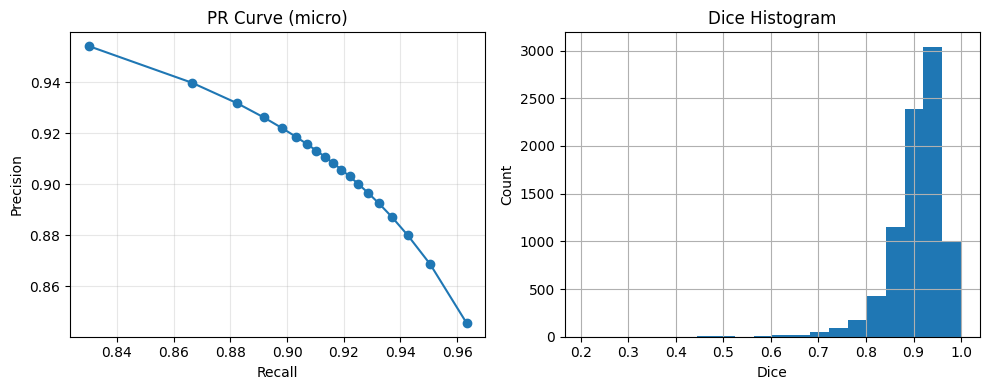

In [7]:
# PR AUC (micro)
pr = pd.read_csv(pr_curve_p)
auc = float(np.trapz(pr["precision"].values, pr["recall"].values))
print("PR AUC:", round(auc, 4))

fig, ax = plt.subplots(1, 2, figsize=(10,4))
ax[0].plot(pr["recall"], pr["precision"], marker="o")
ax[0].set_title("PR Curve (micro)")
ax[0].set_xlabel("Recall")
ax[0].set_ylabel("Precision")
ax[0].grid(alpha=0.3)

df["dice"].hist(bins=20, ax=ax[1])
ax[1].set_title("Dice Histogram")
ax[1].set_xlabel("Dice")
ax[1].set_ylabel("Count")
plt.tight_layout()
plt.show()

In [16]:
import os, numpy as np
from PIL import Image
idx = 2  # sample2
paths = [
    f"{previews_dir}/{idx:03d}_img.png",
    f"{previews_dir}/{idx:03d}_gt.png",
    f"{previews_dir}/{idx:03d}_prob.png",
]
for p in paths:
    print(p, "exists:", os.path.exists(p), "size(B):", os.path.getsize(p) if os.path.exists(p) else -1)
    if os.path.exists(p):
        arr = np.array(Image.open(p))
        print(" shape:", arr.shape, "dtype:", arr.dtype, "min/max:", arr.min(), arr.max())

S:\881project\outputs\step4\eval_test\previews/002_img.png exists: True size(B): 20600
 shape: (256, 256) dtype: uint8 min/max: 119 255
S:\881project\outputs\step4\eval_test\previews/002_gt.png exists: True size(B): 201
 shape: (256, 256) dtype: uint8 min/max: 0 255
S:\881project\outputs\step4\eval_test\previews/002_prob.png exists: True size(B): 209
 shape: (256, 256) dtype: uint8 min/max: 0 254


In [22]:
import os, re, glob, numpy as np, matplotlib.pyplot as plt
from PIL import Image

def list_preview_indices(previews_dir):
    files = glob.glob(os.path.join(previews_dir, "*_img.png"))
    idxs = []
    for f in files:
        m = re.search(r"(\d{3})_img\.png$", f)
        if m: idxs.append(int(m.group(1)))
    idxs = sorted(set(idxs))
    print("available indices:", idxs, "| count:", len(idxs))
    return idxs

def show_preview(previews_dir, idx, cmap_img="gray", cmap_prob="inferno", allow_nearest=True):
    base = os.path.join(previews_dir, f"{idx:03d}")
    p_img, p_gt, p_prob = base + "_img.png", base + "_gt.png", base + "_prob.png"
    missing = [p for p in (p_img, p_gt, p_prob) if not os.path.exists(p)]
    if missing:
        if allow_nearest:
            idxs = list_preview_indices(previews_dir)
            if not idxs:
                raise FileNotFoundError(f"no previews in {previews_dir}")
            nearest = min(idxs, key=lambda x: abs(x - idx))
            print(f"preview {idx:03d} not found, use nearest {nearest:03d}")
            return show_preview(previews_dir, nearest, cmap_img, cmap_prob, allow_nearest=False)
        raise FileNotFoundError(f"Not found: {missing}")

    img  = np.array(Image.open(p_img)).astype(np.float32)
    gt   = np.array(Image.open(p_gt)).astype(np.float32)/255.0
    prob = np.array(Image.open(p_prob)).astype(np.float32)/255.0

    fig, ax = plt.subplots(1,3, figsize=(10,3))
    ax[0].imshow(img, cmap=cmap_img, vmin=0, vmax=255); ax[0].set_title("img"); ax[0].axis("off")
    ax[1].imshow(gt, cmap="gray", vmin=0, vmax=1);      ax[1].set_title("gt");  ax[1].axis("off")
    ax[2].imshow(img, cmap=cmap_img, vmin=0, vmax=255)
    im = ax[2].imshow(prob, cmap=cmap_prob, alpha=0.6, vmin=0, vmax=1)
    ax[2].set_title("img + prob"); ax[2].axis("off")
    plt.colorbar(im, ax=ax[2], fraction=0.046, pad=0.04)
    plt.tight_layout(); plt.show()

available indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11] | count: 12


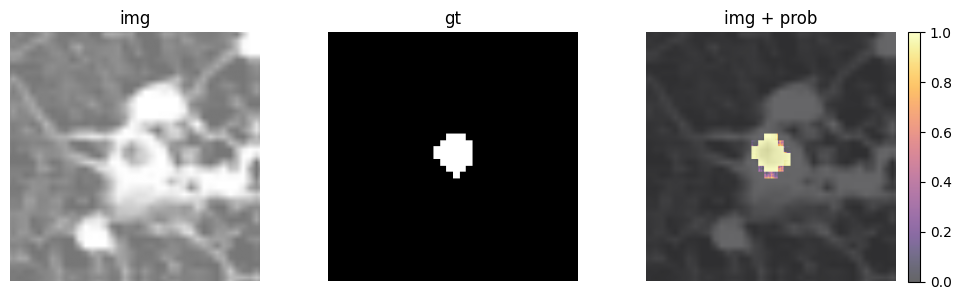

In [33]:
previews_dir = "S:\881project\outputs\step4\eval_test\previews"  # 或 eval_full/previews
list_preview_indices(previews_dir)
show_preview(previews_dir, idx=4)

In [ ]:
# Optional: diameter-binned stats (~approx by dicom_path)
# Note: metrics_per_sample is ROI-level, but only stores dicom_path.
# We approximate by merging a per-slice max diameter (from roi_with_diam.csv) using dicom_path.

roi = pd.read_csv(ROI_CSV)[["dicom_path", "diameter_mm"]]
# If multiple ROIs share same dicom_path, take max diameter as slice proxy
roi_agg = roi.groupby("dicom_path", as_index=False)["diameter_mm"].max().rename(columns={"diameter_mm":"diam_mm_max"})

dfb = df.merge(roi_agg, on="dicom_path", how="left")
print("Merged rows:", len(dfb), "with diameter coverage:", dfb["diam_mm_max"].notna().mean())

# Bin edges and labels (you can tune)
bins = [-1, 6, 10, 1e9]
labels = ["<=6mm", "6-10mm", ">10mm"]
dfb["diam_bin"] = pd.cut(dfb["diam_mm_max"].fillna(-1), bins=bins, labels=labels)

print(dfb.groupby("diam_bin")["dice"].mean().round(3))
print(dfb.groupby("diam_bin")["dice"].count())

FileNotFoundError: [Errno 2] No such file or directory: 'outputs/step2/roi_with_diam.csv'

## How to interpret
- mean_dice / mean_iou: higher is better; Dice ≥ 0.7 usually indicates robust segmentation (task-dependent).
- PR AUC: higher is better; complements Dice by looking at threshold sweep.
- Coverage: Frac Dice ≥ 0.5/0.6/0.7 shows proportion of samples above thresholds.
- Dice histogram: distribution shape; long left tail suggests hard cases.
- Diameter-binned Dice: check performance vs. nodule size bands (approx).